## **1-Importando Biblioteca**

In [0]:
import cv2
import matplotlib.pyplot as plt
import zipfile
import numpy as np

cv2.__version__

'4.1.2'

## **2-Conectando ao google drive**






In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
pose_path = '/content/drive/My Drive/Colab Notebooks/Reconhecimento de Gestos e Ações com Python e OpenCV/pose.zip'
zip_object = zipfile.ZipFile(file = pose_path, mode = "r")
zip_object.extractall("./")

In [0]:
imagens_path = '/content/drive/My Drive/Colab Notebooks/Reconhecimento de Gestos e Ações com Python e OpenCV/imagens.zip'
zip_object = zipfile.ZipFile(file = imagens_path, mode = "r")
zip_object.extractall("./")
zip_object.close()

## **3- Carregando modelo mobii e COCO/Pre rede neural**

In [0]:
arquivo_proto = '/content/pose/body/mpi/pose_deploy_linevec_faster_4_stages.prototxt'
arquivo_pesos = '/content/pose/body/mpi/pose_iter_160000.caffemodel'

numero_de_pontos=15
pares_pontos = [[0, 1], [1, 2], [2, 3], [3, 4], [1, 5], [5, 6], [6, 7],[1,14],
               [14, 8], [8, 9], [9, 10], [14, 11], [11, 12], [12, 13]]

In [0]:
pares_pontos

[[0, 1],
 [1, 2],
 [2, 3],
 [3, 4],
 [1, 5],
 [5, 6],
 [6, 7],
 [1, 14],
 [14, 8],
 [8, 9],
 [9, 10],
 [14, 11],
 [11, 12],
 [12, 13]]

In [0]:
cor_ponto , cor_linha = (255,128,0) , (7,62,248)

## **4- Carregando imagem no drive**

In [0]:
imagem_body = cv2.imread('/content/imagens/body/single/single_3.jpg')

In [0]:
imagem_body.shape

(337, 600, 3)

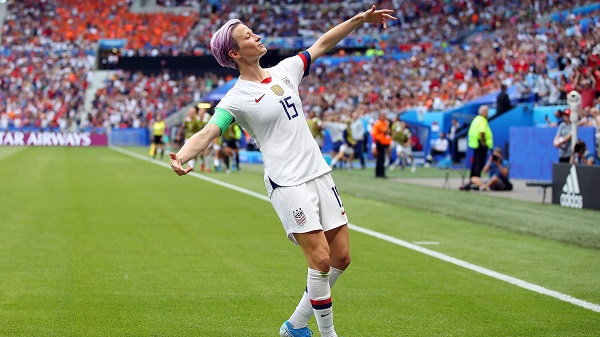

In [0]:
from google.colab.patches import cv2_imshow
cv2_imshow(imagem_body)

In [0]:
imagem_copia = np.copy(imagem_body)

In [0]:
imagem_largura = imagem_body.shape[1]
imagem_altura = imagem_body.shape[0]

In [0]:
imagem_altura, imagem_altura

(337, 337)

## **5- Carregando modelo**

In [0]:
modelo = cv2.dnn.readNetFromCaffe(arquivo_proto,arquivo_pesos)

## **6- Definir dimensões da imagem de entrada**

In [0]:
altura_entrada = 368
largura_entrada = int((altura_entrada / imagem_altura)*imagem_largura)


In [0]:
largura_entrada

655

## **7- Converter imagem do formato openCV para formato blob caffe**

In [0]:
blob_entrada = cv2.dnn.blobFromImage(imagem_body,scalefactor = 1.0/255,
                                     size=(largura_entrada, altura_entrada),
                                     mean= (0,0,0), swapRB= False,
                                     crop = False)

## **8- Saida do mapa de calor**

In [0]:
modelo.setInput(blob_entrada)
saida = modelo.forward()

In [0]:
saida.shape

(1, 44, 46, 82)

In [0]:
altura = saida.shape[2]
largura = saida.shape[3]

In [0]:
altura , largura

(46, 82)

## **9- Plotando as saidas na imagem**



In [0]:
pontos = []
limite = 0.1
for i in range(numero_de_pontos):
  mapa_confianca = saida[0,i, :, :]
  _,confianca, _, ponto= cv2.minMaxLoc(mapa_confianca)
  #print(confianca)
  #print(ponto)
  x = (imagem_largura * ponto[0])/largura
  y = (imagem_altura * ponto[1])/altura
  if confianca > limite:
    cv2.circle(imagem_copia, (int(x), int(y)), 8,cor_ponto, thickness = -1, 
               lineType= cv2.FILLED)
    cv2.putText(imagem_copia, "{}".format(i), (int(x), int(y)), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255),3, 
                lineType=cv2.LINE_AA)
    pontos.append((int(x), int(y)))
  else:
    pontos.append(None)

  

In [0]:
len(pontos)

15

In [0]:
pontos

[(226, 21),
 (248, 65),
 (226, 95),
 (204, 131),
 (175, 153),
 (278, 65),
 (314, 43),
 (358, 14),
 (285, 183),
 (314, 256),
 (321, 329),
 (314, 168),
 (336, 256),
 (292, 315),
 (278, 124)]

## **10- Criando uma mascara para desenho do esqueleto**

In [0]:
tamanho = cv2.resize(imagem_body, (imagem_largura,imagem_altura))
mapa_suave = cv2.GaussianBlur(tamanho, (3,3), 0,0 )
mascara_mapa =  np.uint8(mapa_suave > limite)


## **11- Desenhando esqueleto: quando temos os pontos chaves, apenas juntamos os pares**

In [0]:
for par in pares_pontos:
  parte_A = par[0]
  parte_B = par[1]
  if pontos[parte_A] and pontos [parte_B]:
    cv2.line(imagem_body, pontos[parte_A], pontos[parte_B], cor_linha,3)
    cv2.circle(imagem_body, pontos[parte_A], 8 , cor_ponto,thickness=-1, lineType=cv2.LINE_AA)

    cv2.line(mascara_mapa, pontos[parte_A], pontos[parte_B], cor_linha,3)
    cv2.circle(mascara_mapa, pontos[parte_A], 8 , cor_ponto,thickness=-1, lineType=cv2.LINE_AA)



## **12- Exibindo saidas**

(-0.5, 599.5, 336.5, -0.5)

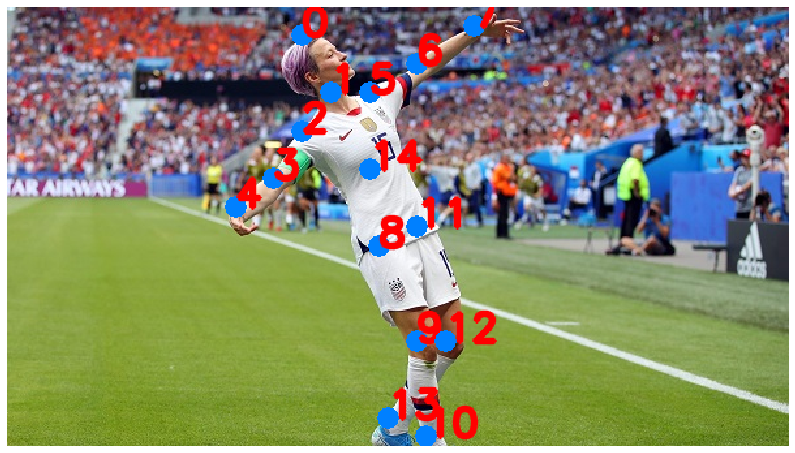

In [0]:
plt.figure(figsize=   [14,10])
plt.imshow(cv2.cvtColor(imagem_copia, cv2.COLOR_BGR2RGB))
plt.axis('off')

(-0.5, 599.5, 336.5, -0.5)

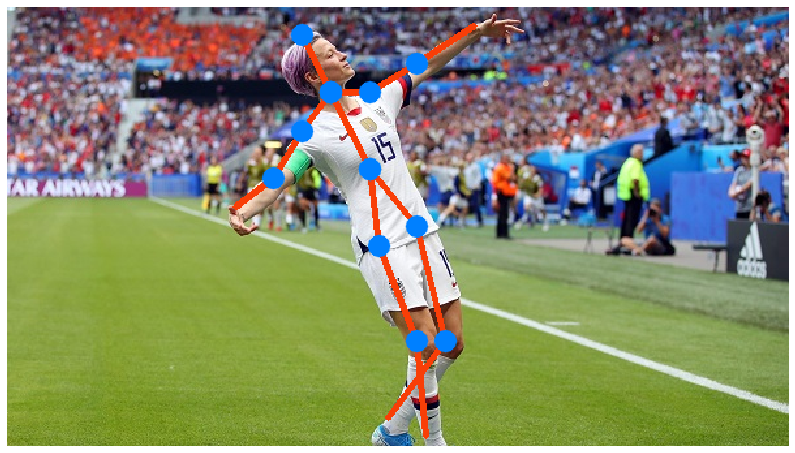

In [0]:
plt.figure(figsize=   [14,10])
plt.imshow(cv2.cvtColor(imagem_body, cv2.COLOR_BGR2RGB))
plt.axis('off')


(-0.5, 599.5, 336.5, -0.5)

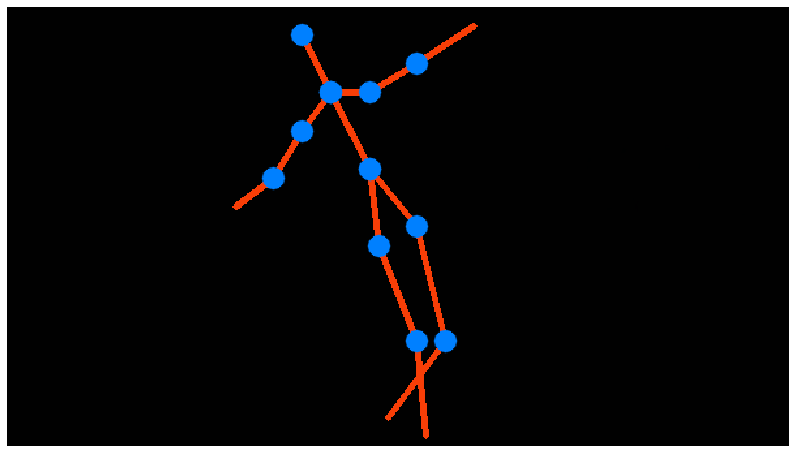

In [0]:
plt.figure(figsize=   [14,10])
plt.imshow(cv2.cvtColor(mascara_mapa, cv2.COLOR_BGR2RGB))
plt.axis('off')